# Eikonal traveltime tomography for seismic exploration scenarios

@Author: Ettore Biondi - ebiondi@caltech.edu

To use this notebook, we need pykonal installed.
1. `conda env create -n occa -f ../env.yml`
2. `conda activate occa`
2. `conda install cython`
3. `wget https://codeload.github.com/malcolmw/pykonal/zip/refs/tags/0.2.3b3`
4. `unzip 0.2.3b3 && rm 0.2.3b3`
5. `pip install -e pykonal-0.2.3b3`

In this notebook, we will apply the Eikonal tomography operators on a more realistic example using the Marmousi2 model. We will test two scenarios; namely, a cross-well case and a surface-acquisition test.

In [1]:
import numpy as np
import occamypy as o
import eikonal2d as k

# Plotting
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
rcParams.update({
    'image.cmap'     : 'jet_r',
    'image.aspect'   : 'auto',
    'axes.grid'      : False,
    'figure.figsize' : (10, 6),
    'savefig.dpi'    : 300,
    'axes.labelsize' : 14,
    'axes.titlesize' : 16,
    'font.size'      : 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
})

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Cross-well tomography

Let's plot the true model. Along with the geometry for the cross-well tomography example using a section of the Marmousi.

In [2]:
# Reading velocity model
nx = 1700
nz = 350
dx = 0.01
dz = 0.01
ox = 0.0
oz = 0.0
MarmTrue = np.reshape(np.fromfile("data/Marmousi2Vp.bin", dtype=">f"), (nx,nz))

MarmTrue = MarmTrue[600:1200,:]

desampling=4
dx *= desampling
dz *= desampling
MarmTrue = MarmTrue[::desampling,::desampling]
nx,nz = MarmTrue.shape

x = np.linspace(0,(nx-1)*dx, nx)
z = np.linspace(0,(nz-1)*dz, nz)

# Velocity model
# Velocity model
vvTrue = o.VectorNumpy((nx,nz), ax_info=[o.AxInfo(nx, 0, dx, "x [km]"), o.AxInfo(nz, 0, dz, "z [km]")])
vvTrue[:] = MarmTrue

In [3]:
# Source/Receiver positions
SouPos = np.array([[int(nx*0.5),iz] for iz in np.arange(0,nz,2)])
RecPos = np.array([[0,iz] for iz in np.arange(0,nz,2)]+[[nx-1,iz] for iz in np.arange(0,nz,2)])

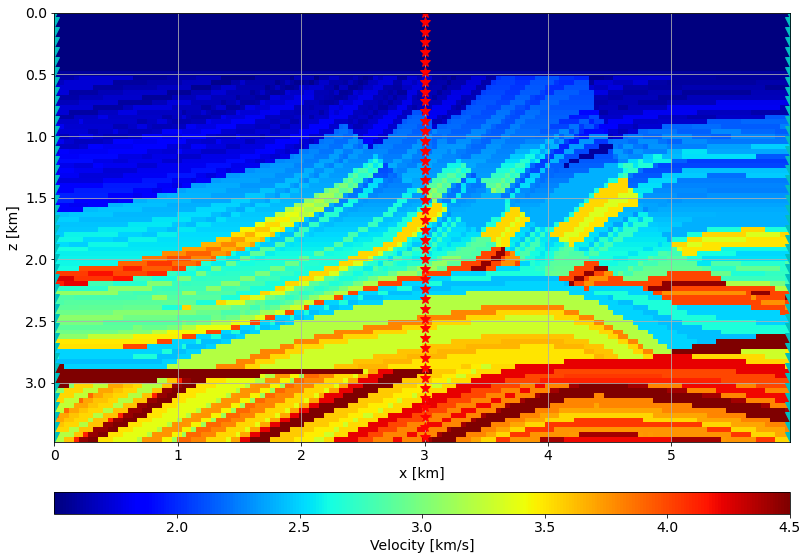

In [4]:
fig, ax = plt.subplots(figsize=(19,8))
im = ax.imshow(vvTrue.plot().T, extent=[x[0], x[-1], z[-1], z[0]], aspect="equal", cmap='jet')
ax.plot(SouPos[:,0]*dx,SouPos[:,1]*dz,"r*",ms=10)
ax.plot(RecPos[:,0]*dx,RecPos[:,1]*dz,"cv",ms=10)
ax = plt.gca()
ax.grid()
plt.xlabel(vvTrue.ax_info[0].l)
plt.ylabel(vvTrue.ax_info[1].l)
cbar = plt.colorbar(im, orientation="horizontal",
                    cax=make_axes_locatable(ax).append_axes("bottom", size="5%", pad=0.7))
cbar.set_label('Velocity [km/s]')
plt.tight_layout()
plt.show()

Now, we can proceed to generate the observed travel times.

In [5]:
# Data vector
tt_obs = o.VectorNumpy((SouPos.shape[0], RecPos.shape[0]),
                        ax_info=[o.AxInfo(SouPos.shape[0], 0, 1, "sou_id"), o.AxInfo(RecPos.shape[0], 0, 1, "rec_id")])
tt_obs.zero()

# Setting Forward non-linear operator
Eik2D_Op = k.EikonalTT_2D(vvTrue, tt_obs, SouPos, RecPos)
Eik2D_Op.forward(False, vvTrue, tt_obs)

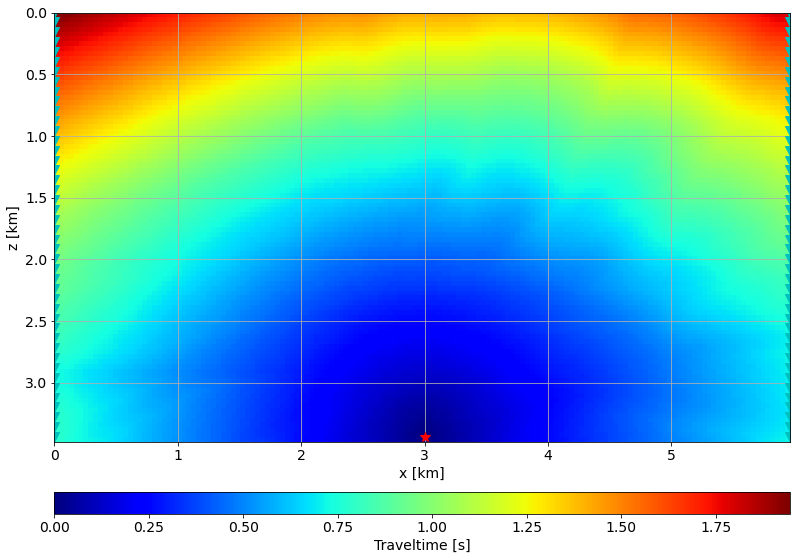

In [6]:
sou_id = -1
fig, ax = plt.subplots(figsize=(19,8))
im = ax.imshow(Eik2D_Op.tt_maps[sou_id].T, extent=[x[0], x[-1], z[-1], z[0]], aspect="equal", cmap='jet')
ax.plot(SouPos[sou_id,0]*dx,SouPos[sou_id,1]*dz,"r*",ms=10)
ax.plot(RecPos[:,0]*dx,RecPos[:,1]*dz,"cv",ms=10)
ax = plt.gca()
ax.grid()
plt.xlabel(vvTrue.ax_info[0].l)
plt.ylabel(vvTrue.ax_info[1].l)
cbar = plt.colorbar(im, orientation="horizontal",
                    cax=make_axes_locatable(ax).append_axes("bottom", size="5%", pad=0.7))
cbar.set_label('Traveltime [s]')
plt.tight_layout()
plt.show()

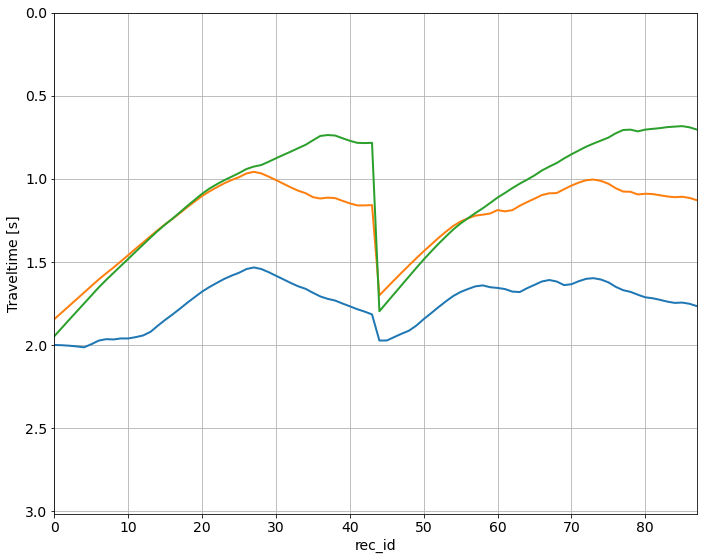

In [7]:
# Plotting traveltime vector
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(tt_obs.ax_info[1].plot(), tt_obs[0,:], lw=2)
ax.plot(tt_obs.ax_info[1].plot(), tt_obs[15,:], lw=2)
ax.plot(tt_obs.ax_info[1].plot(), tt_obs[-1,:], lw=2)
ax.grid()
plt.xlabel(tt_obs.ax_info[1].l)
plt.ylabel("Traveltime [s]")
ax.set_ylim(tt_obs.max()+1.0, 0)
ax.set_xlim(tt_obs.ax_info[1].o, tt_obs.ax_info[1].last)
plt.tight_layout()
plt.show()

The initial model will be constructed by smoothing the true model.

In [8]:
# Creating problem object using Smoothing filter
vvInit = vvTrue.clone()
G = o.GaussianFilter(vvInit, 2.5)
vvInit = G * vvTrue

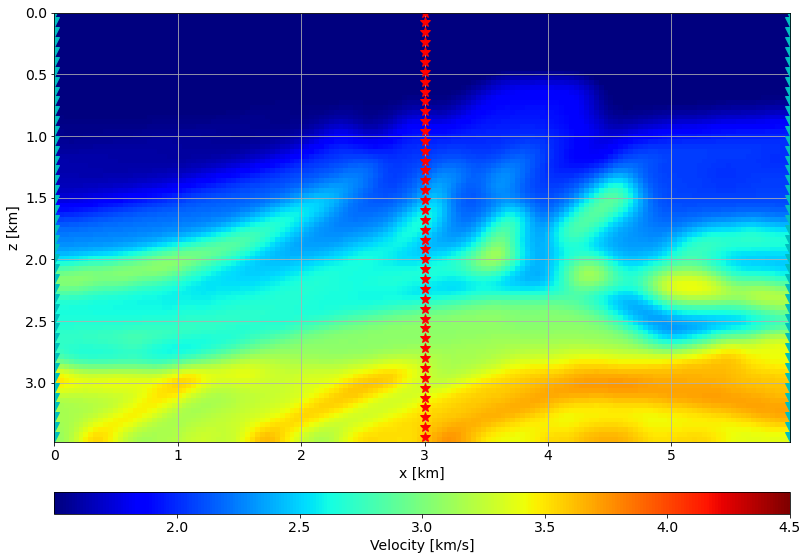

In [9]:
fig, ax = plt.subplots(figsize=(19,8))
im = ax.imshow(vvInit.plot().T, extent=[x[0], x[-1], z[-1], z[0]], aspect="equal", cmap='jet', 
               vmin=vvTrue.min(), vmax=vvTrue.max())
ax.plot(SouPos[:,0]*dx,SouPos[:,1]*dz,"r*",ms=10)
ax.plot(RecPos[:,0]*dx,RecPos[:,1]*dz,"cv",ms=10)
ax = plt.gca()
ax.grid()
plt.xlabel(vvTrue.ax_info[0].l)
plt.ylabel(vvTrue.ax_info[1].l)
cbar = plt.colorbar(im, orientation="horizontal",
                    cax=make_axes_locatable(ax).append_axes("bottom", size="5%", pad=0.7))
cbar.set_label('Velocity [km/s]')
plt.tight_layout()
plt.show()

Let's set up the inversion problem and solve it.

In [10]:
# Instantiating non-linear operator
Eik2D_Lin_Op = k.EikonalTT_lin_2D(vvInit, tt_obs, SouPos, RecPos, tt_maps=Eik2D_Op.tt_maps)
Eik2D_NlOp = o.NonlinearOperator(Eik2D_Op, Eik2D_Lin_Op, Eik2D_Lin_Op.set_vel)

In [11]:
# instantiate solver
BFGSsolver = o.LBFGS(o.BasicStopper(niter=100, tolg_proj=1e-32), m_steps=30)
G = o.GaussianFilter(vvInit, 3.5)
Eik2D_Inv_NlOp = o.NonlinearOperator(Eik2D_Op, Eik2D_Lin_Op * G, Eik2D_Lin_Op.set_vel)

L2_tt_prob = o.NonlinearLeastSquares(vvInit.clone(), tt_obs, Eik2D_Inv_NlOp, 
                                     minBound=vvInit.clone().set(1.0),  # min velocity: 1.0 km/s
                                     maxBound=vvInit.clone().set(5.0)) # max velocity: 5.0 km/s

In [12]:
BFGSsolver.run(L2_tt_prob, verbose=True)

##########################################################################################
Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS) algorithm 
Maximum number of steps to be used for Hessian inverse estimation: 30 
Restart folder: /tmp/restart_2022-04-18T11-40-35.415931/
##########################################################################################

iter = 000, obj = 7.82079e+01, resnorm = 1.25e+01, gradnorm = 6.43e+00, feval = 1, geval = 1
iter = 001, obj = 1.56800e+01, resnorm = 5.60e+00, gradnorm = 1.23e+00, feval = 2, geval = 2
iter = 002, obj = 1.10747e+01, resnorm = 4.71e+00, gradnorm = 8.82e-01, feval = 3, geval = 3
iter = 003, obj = 5.34776e+00, resnorm = 3.27e+00, gradnorm = 6.37e-01, feval = 4, geval = 4
iter = 004, obj = 3.42891e+00, resnorm = 2.62e+00, gradnorm = 5.18e-01, feval = 5, geval = 5
iter = 005, obj = 1.88919e+00, resnorm = 1.94e+00, gradnorm = 3.14e-01, feval = 6, geval = 6
iter = 006, obj = 1.37063e+00, resnorm = 1.66e+00, gradnorm = 2

iter = 083, obj = 5.62811e-02, resnorm = 3.36e-01, gradnorm = 4.43e-03, feval = 84, geval = 84
iter = 084, obj = 5.59992e-02, resnorm = 3.35e-01, gradnorm = 4.42e-03, feval = 85, geval = 85
iter = 085, obj = 5.55890e-02, resnorm = 3.33e-01, gradnorm = 4.53e-03, feval = 86, geval = 86
iter = 086, obj = 5.50239e-02, resnorm = 3.32e-01, gradnorm = 5.12e-03, feval = 87, geval = 87
iter = 087, obj = 5.43462e-02, resnorm = 3.30e-01, gradnorm = 5.89e-03, feval = 88, geval = 88
iter = 088, obj = 5.37072e-02, resnorm = 3.28e-01, gradnorm = 6.48e-03, feval = 89, geval = 89
iter = 089, obj = 5.31341e-02, resnorm = 3.26e-01, gradnorm = 6.48e-03, feval = 90, geval = 90
iter = 090, obj = 5.26254e-02, resnorm = 3.24e-01, gradnorm = 6.03e-03, feval = 91, geval = 91
iter = 091, obj = 5.22094e-02, resnorm = 3.23e-01, gradnorm = 5.62e-03, feval = 92, geval = 92
iter = 092, obj = 5.19075e-02, resnorm = 3.22e-01, gradnorm = 5.59e-03, feval = 93, geval = 93
iter = 093, obj = 5.16669e-02, resnorm = 3.21e-01,

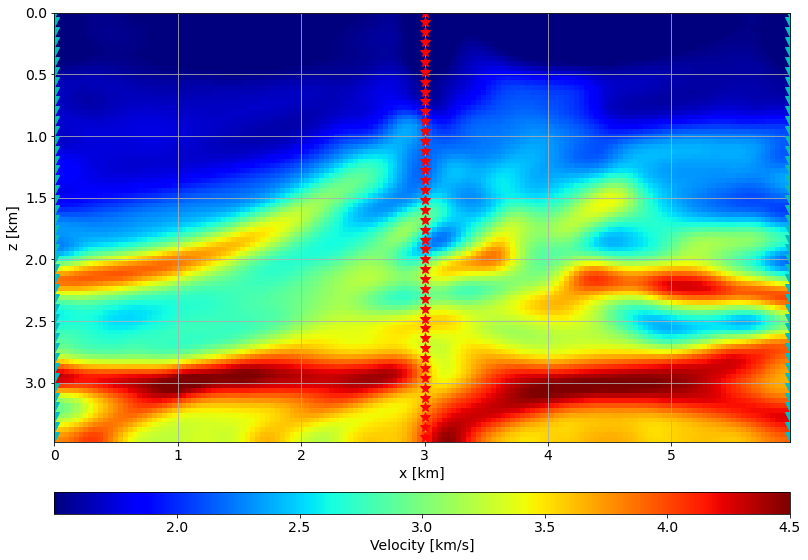

In [13]:
fig, ax = plt.subplots(figsize=(19,8))
im = ax.imshow(L2_tt_prob.model.plot().T, extent=[x[0], x[-1], z[-1], z[0]], aspect="equal", cmap='jet', 
               vmin=vvTrue.min(), vmax=vvTrue.max())
ax.plot(SouPos[:,0]*dx,SouPos[:,1]*dz,"r*",ms=10)
ax.plot(RecPos[:,0]*dx,RecPos[:,1]*dz,"cv",ms=10)
ax = plt.gca()
ax.grid()
plt.xlabel(vvTrue.ax_info[0].l)
plt.ylabel(vvTrue.ax_info[1].l)
cbar = plt.colorbar(im, orientation="horizontal",
                    cax=make_axes_locatable(ax).append_axes("bottom", size="5%", pad=0.7))
cbar.set_label('Velocity [km/s]')
plt.tight_layout()
plt.show()

### First-break surface tomography

In this test we will be estimating the subsurface velocity using a surface acquisition.

In [14]:
# Reading velocity model
nx = 1700
nz = 350
dx = 0.01
dz = 0.01
ox = 0.0
oz = 0.0
MarmTrue = np.reshape(np.fromfile("data/Marmousi2Vp.bin", dtype=">f"), (nx,nz))

desampling=4
dx *= desampling
dz *= desampling
MarmTrue = MarmTrue[::desampling,::desampling]
nx,nz = MarmTrue.shape

x = np.linspace(0,(nx-1)*dx, nx)
z = np.linspace(0,(nz-1)*dz, nz)

# Velocity model
# Velocity model
vvTrue = o.VectorNumpy((nx,nz), ax_info=[o.AxInfo(nx, 0, dx, "x [km]"), o.AxInfo(nz, 0, dz, "z [km]")])
vvTrue[:] = MarmTrue

In [15]:
# Source/Receiver positions
SouPos = np.array([[ix,0] for ix in np.arange(0,nx,10)])
RecPos = np.array([[ix,0] for ix in np.arange(0,nx,2)])

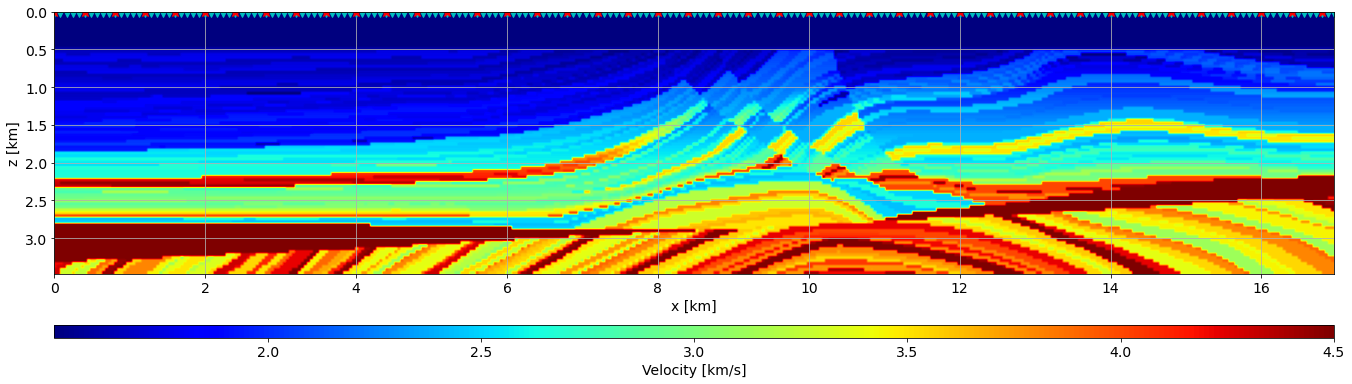

In [16]:
fig, ax = plt.subplots(figsize=(19,8))
im = ax.imshow(vvTrue.plot().T, extent=[x[0], x[-1], z[-1], z[0]], aspect="equal", cmap='jet')
ax.plot(RecPos[:,0]*dx,RecPos[:,1]*dz,"cv",ms=10)
ax.plot(SouPos[:,0]*dx,SouPos[:,1]*dz,"r*",ms=10)
ax = plt.gca()
ax.grid()
plt.xlabel(vvTrue.ax_info[0].l)
plt.ylabel(vvTrue.ax_info[1].l)
cbar = plt.colorbar(im, orientation="horizontal",
                    cax=make_axes_locatable(ax).append_axes("bottom", size="5%", pad=0.7))
cbar.set_label('Velocity [km/s]')
plt.tight_layout()
plt.show()

In [17]:
# Data vector
tt_obs = o.VectorNumpy((SouPos.shape[0], RecPos.shape[0]),
                        ax_info=[o.AxInfo(SouPos.shape[0], 0, 1, "sou_id"), o.AxInfo(RecPos.shape[0], 0, 1, "rec_id")])
tt_obs.zero()

# Setting Forward non-linear operator
Eik2D_Op = k.EikonalTT_2D(vvTrue, tt_obs, SouPos, RecPos)
Eik2D_Op.forward(False, vvTrue, tt_obs)

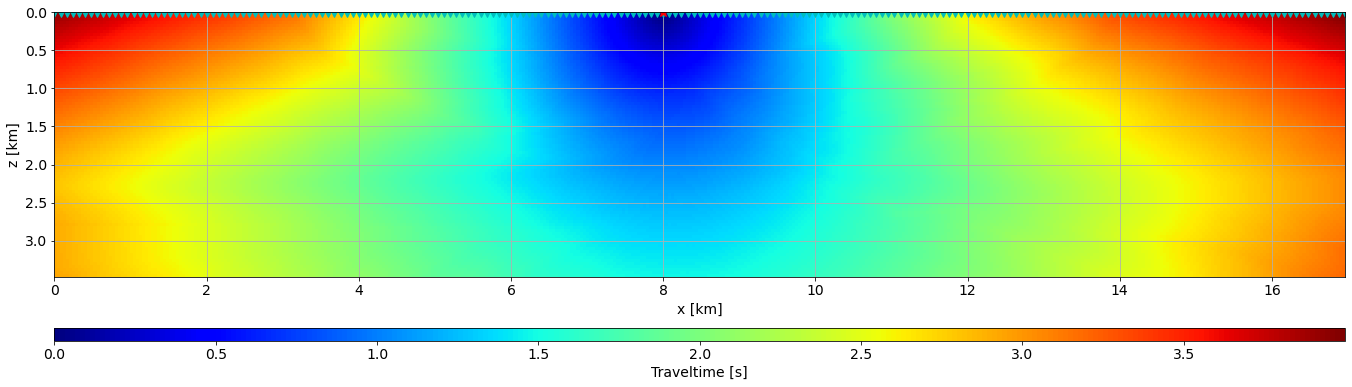

In [18]:
sou_id = 20
fig, ax = plt.subplots(figsize=(19,8))
im = ax.imshow(Eik2D_Op.tt_maps[sou_id].T, extent=[x[0], x[-1], z[-1], z[0]], aspect="equal", cmap='jet')
ax.plot(RecPos[:,0]*dx,RecPos[:,1]*dz,"cv",ms=10)
ax.plot(SouPos[sou_id,0]*dx,SouPos[sou_id,1]*dz,"r*",ms=10)
ax = plt.gca()
ax.grid()
plt.xlabel(vvTrue.ax_info[0].l)
plt.ylabel(vvTrue.ax_info[1].l)
cbar = plt.colorbar(im, orientation="horizontal",
                    cax=make_axes_locatable(ax).append_axes("bottom", size="5%", pad=0.7))
cbar.set_label('Traveltime [s]')
plt.tight_layout()
plt.show()

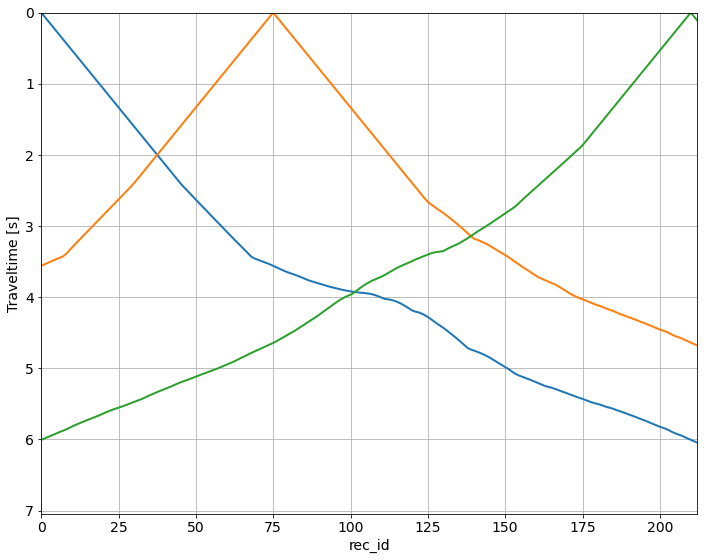

In [19]:
# Plotting traveltime vector
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(tt_obs.ax_info[1].plot(), tt_obs[0,:], lw=2)
ax.plot(tt_obs.ax_info[1].plot(), tt_obs[15,:], lw=2)
ax.plot(tt_obs.ax_info[1].plot(), tt_obs[-1,:], lw=2)
ax.grid()
plt.xlabel(tt_obs.ax_info[1].l)
plt.ylabel("Traveltime [s]")
ax.set_ylim(tt_obs.max()+1.0, 0)
ax.set_xlim(tt_obs.ax_info[1].o, tt_obs.ax_info[1].last)
plt.tight_layout()
plt.show()

In [20]:
# Creating problem object using Smoothing filter
vvInit = vvTrue.clone()
G = o.GaussianFilter(vvInit, 2.5)
# vvInit[:] = np.mean(vvTrue[:],axis=0)
vvInit = G * vvTrue

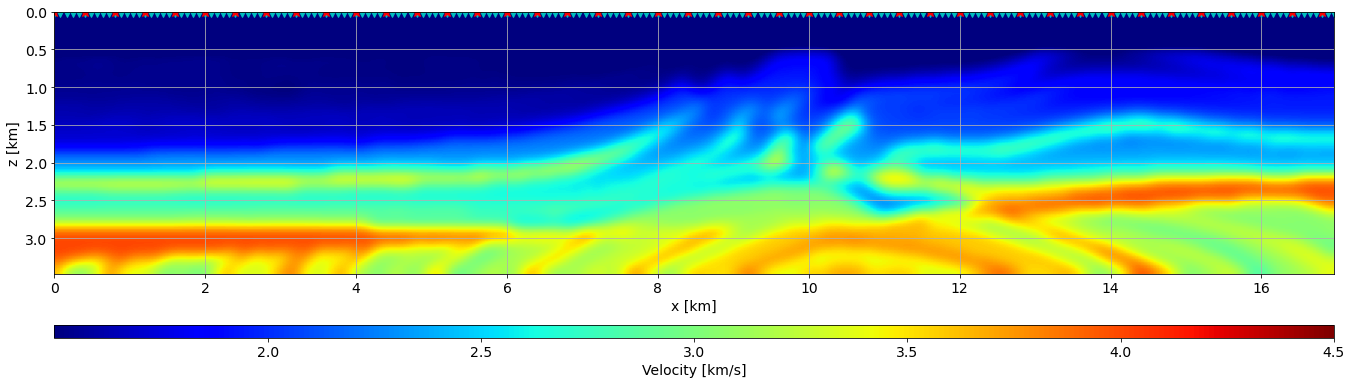

In [21]:
fig, ax = plt.subplots(figsize=(19,8))
im = ax.imshow(vvInit.plot().T, extent=[x[0], x[-1], z[-1], z[0]], aspect="equal", cmap='jet', 
               vmin=vvTrue.min(), vmax=vvTrue.max())
ax.plot(RecPos[:,0]*dx,RecPos[:,1]*dz,"cv",ms=10)
ax.plot(SouPos[:,0]*dx,SouPos[:,1]*dz,"r*",ms=10)
ax = plt.gca()
ax.grid()
plt.xlabel(vvTrue.ax_info[0].l)
plt.ylabel(vvTrue.ax_info[1].l)
cbar = plt.colorbar(im, orientation="horizontal",
                    cax=make_axes_locatable(ax).append_axes("bottom", size="5%", pad=0.7))
cbar.set_label('Velocity [km/s]')
plt.tight_layout()
plt.show()

In [22]:
# Instantiating non-linear operator
Eik2D_Lin_Op = k.EikonalTT_lin_2D(vvInit, tt_obs, SouPos, RecPos, tt_maps=Eik2D_Op.tt_maps)
Eik2D_NlOp = o.NonlinearOperator(Eik2D_Op, Eik2D_Lin_Op, Eik2D_Lin_Op.set_vel)

In [23]:
# instantiate solver
BFGSsolver = o.LBFGS(o.BasicStopper(niter=100, tolg_proj=1e-32), m_steps=30)
Eik2D_Inv_NlOp = o.NonlinearOperator(Eik2D_Op, Eik2D_Lin_Op * G, Eik2D_Lin_Op.set_vel)

L2_tt_prob = o.NonlinearLeastSquares(vvInit.clone(), tt_obs, Eik2D_Inv_NlOp, 
                                     minBound=vvInit.clone().set(1.0),  # min velocity: 1.0 km/s
                                     maxBound=vvInit.clone().set(5.0)) # max velocity: 5.0 km/s

In [24]:
BFGSsolver.run(L2_tt_prob, verbose=True)

##########################################################################################
Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS) algorithm 
Maximum number of steps to be used for Hessian inverse estimation: 30 
Restart folder: /tmp/restart_2022-04-18T11-47-40.034820/
##########################################################################################

iter = 000, obj = 1.21361e+03, resnorm = 4.93e+01, gradnorm = 5.51e+01, feval = 1, geval = 1
iter = 001, obj = 4.04259e+02, resnorm = 2.84e+01, gradnorm = 2.87e+01, feval = 2, geval = 2
iter = 002, obj = 7.41082e+01, resnorm = 1.22e+01, gradnorm = 7.51e+00, feval = 3, geval = 3
iter = 003, obj = 2.87076e+01, resnorm = 7.58e+00, gradnorm = 3.29e+00, feval = 4, geval = 4
iter = 004, obj = 1.76349e+01, resnorm = 5.94e+00, gradnorm = 2.29e+00, feval = 5, geval = 5
iter = 005, obj = 1.18068e+01, resnorm = 4.86e+00, gradnorm = 1.64e+00, feval = 6, geval = 6
iter = 006, obj = 8.80404e+00, resnorm = 4.20e+00, gradnorm = 1

iter = 083, obj = 1.03405e-01, resnorm = 4.55e-01, gradnorm = 3.18e-02, feval = 84, geval = 84
iter = 084, obj = 1.00573e-01, resnorm = 4.48e-01, gradnorm = 3.33e-02, feval = 85, geval = 85
iter = 085, obj = 9.79521e-02, resnorm = 4.43e-01, gradnorm = 3.40e-02, feval = 86, geval = 86
iter = 086, obj = 9.56032e-02, resnorm = 4.37e-01, gradnorm = 2.77e-02, feval = 87, geval = 87
iter = 087, obj = 9.29449e-02, resnorm = 4.31e-01, gradnorm = 2.94e-02, feval = 88, geval = 88
iter = 088, obj = 9.04654e-02, resnorm = 4.25e-01, gradnorm = 3.28e-02, feval = 89, geval = 89
iter = 089, obj = 8.76738e-02, resnorm = 4.19e-01, gradnorm = 3.69e-02, feval = 90, geval = 90
iter = 090, obj = 8.63592e-02, resnorm = 4.16e-01, gradnorm = 3.22e-02, feval = 91, geval = 91
iter = 091, obj = 8.44278e-02, resnorm = 4.11e-01, gradnorm = 2.42e-02, feval = 92, geval = 92
iter = 092, obj = 8.32277e-02, resnorm = 4.08e-01, gradnorm = 2.32e-02, feval = 93, geval = 93
iter = 093, obj = 8.11617e-02, resnorm = 4.03e-01,

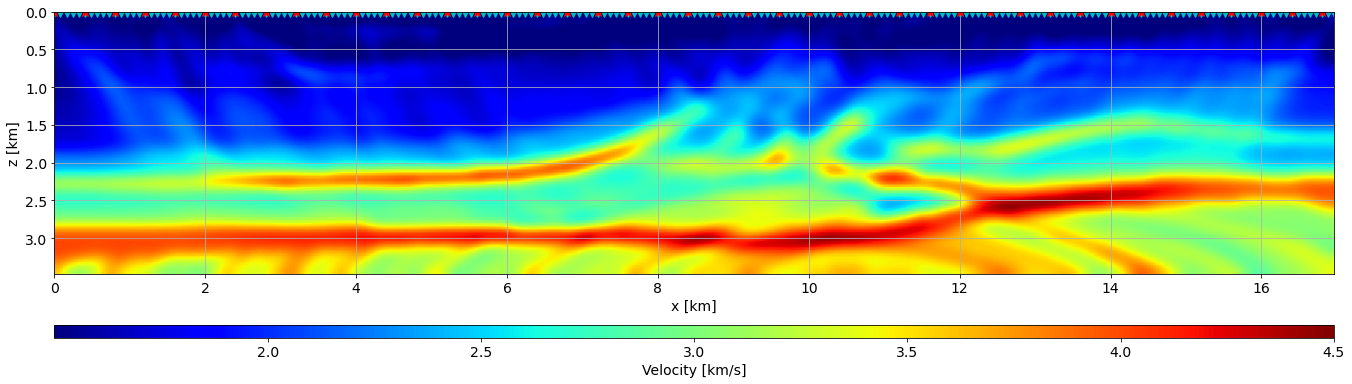

In [25]:
fig, ax = plt.subplots(figsize=(19,8))
im = ax.imshow(L2_tt_prob.model.plot().T, extent=[x[0], x[-1], z[-1], z[0]], aspect="equal", cmap='jet', 
               vmin=vvTrue.min(), vmax=vvTrue.max())
ax.plot(RecPos[:,0]*dx,RecPos[:,1]*dz,"cv",ms=10)
ax.plot(SouPos[:,0]*dx,SouPos[:,1]*dz,"r*",ms=10)
ax = plt.gca()
ax.grid()
plt.xlabel(vvTrue.ax_info[0].l)
plt.ylabel(vvTrue.ax_info[1].l)
cbar = plt.colorbar(im, orientation="horizontal",
                    cax=make_axes_locatable(ax).append_axes("bottom", size="5%", pad=0.7))
cbar.set_label('Velocity [km/s]')
plt.tight_layout()
plt.show()